# Long Short Term Memory NN model for Network Rate Prediction

* imports and data acquisition 
* slice the data to keep only CERN-PROD to BNL-ATLAS (Production Input) transfers (filtered by site)
* define the model
* Make predictions predictions:
 * for one transfer based in x previous transfers (x window size).
 * for a transfer y transfers in the future based on the best window size.


In [1]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

#### RSE to Site

In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Get data

In [47]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if rse2site[r['src_rse']] != 'CERN-PROD':
        continue
    if rse2site[r['dst_rse']] != 'BNL-ATLAS':
        continue
    if not count%100000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = (data.SIZE/(data['ENDED'] - data['STARTED']))
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']

['fts_2017-01-31', 'fts_2017-02-01', 'fts_2017-02-02', 'fts_2017-02-03', 'fts_2017-02-04', 'fts_2017-02-05', 'fts_2017-02-06', 'fts_2017-02-07', 'fts_2017-02-08']
0
100000
Reading took 597.2926027774811 seconds.


#### Slice the data to get only (CERN-->BNL prod input) transfers

In [48]:
cut = data.where(data.LINK == 'CERN-PROD__BNL-ATLAS__Production Input').dropna()
cut = cut.sort_values(by='STARTED')

#### Make predictions for all the transfers with window sizes from 1 to 100.

In [63]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [117]:
cut['N_RATE'] = cut.N_RATE/(1024*1024)

In [143]:

layers = 1
connections = 64
lookback=80
model = Sequential()
for i in range(1, layers):
    model.add(LSTM(connections, input_shape=(None, lookback),return_sequences=True))
model.add(LSTM(connections, input_shape=(None, lookback)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
scalerx = MinMaxScaler(feature_range=(0, 1.))
scalery = MinMaxScaler(feature_range=(0, 1.))
x = scalerx.fit_transform(cut.N_RATE.values)
#y = scalery.fit_transform(np.append(np.array([0]),cut.N_RATE.values[:-1]))
y = scalery.fit_transform(cut.N_RATE.values)
x,y = create_dataset(np.array([x,y]).T, lookback)
x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
batchsize = connections * layers
print('fitting...')
model.fit(x, y, epochs=1, batch_size=connections*layers, shuffle=False)
print('predicting...')
pred = model.predict(x, batch_size=1)
pred = scalery.inverse_transform(pred)
cut['N_PRED'] = np.append(np.array([0]*(lookback+1)),pred)
print('Done.')

/home/ivukotic/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1)

fitting...
Epoch 1/1
13923/13923 [==============================] - 0s - loss: 0.0067     
predicting...
Done.


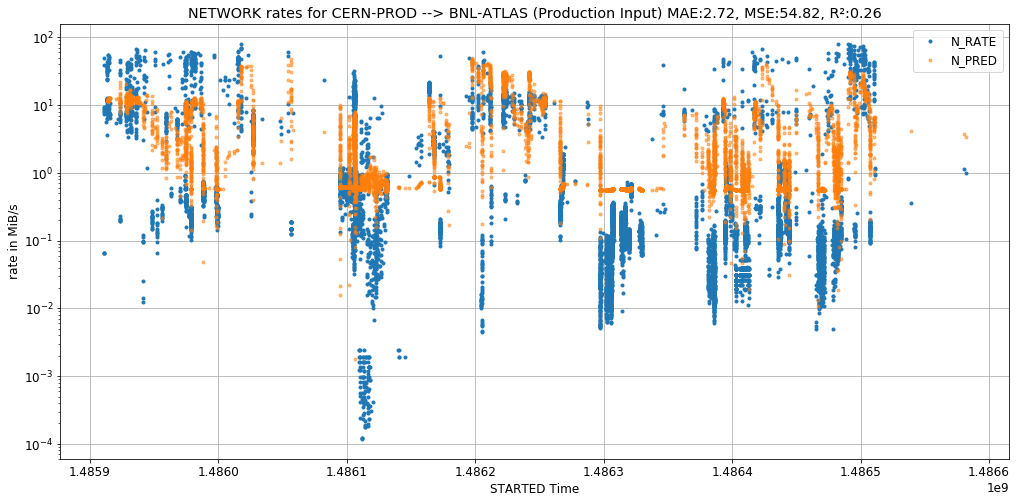

In [134]:
plt.plot(cut.STARTED, cut.N_RATE,'.')
plt.plot(cut.STARTED, cut.N_PRED, '.', alpha=0.5)
n_mae = mae(cut.N_RATE, cut.N_PRED)
n_mse = mse(cut.N_RATE, cut.N_PRED)
n_r2 = r2(cut.N_RATE, cut.N_PRED)
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS (Production Input) MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(n_mae, n_mse,n_r2))
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('STARTED Time')
plt.ylabel('rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

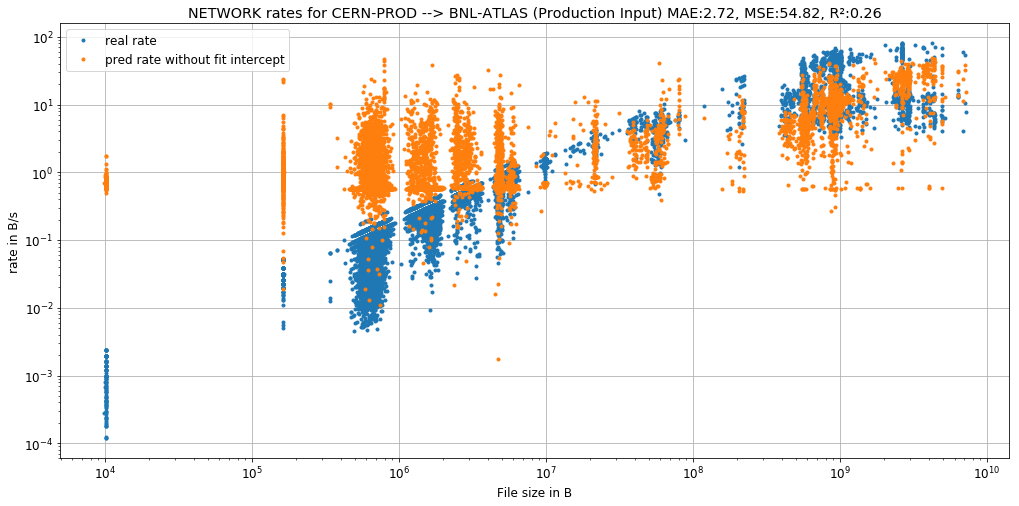

In [135]:
plt.plot(cut.SIZE, cut.N_RATE,'.', label='real rate')
plt.plot(cut.SIZE, cut.N_PRED,'.', label='pred rate without fit intercept')
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS (Production Input) MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(n_mae, n_mse,n_r2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('File size in B')
plt.ylabel('rate in B/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

#### For the best window size, make predictions in the future (1 to 100 transfers ahead of the window)

In [82]:
r2_scores_ahead = []
pred = cut['N_PRED_8'].values
r2_scores_ahead.append(r2(cut.N_RATE, pred))
for t_ahead in range(1,101):
    pred = np.append(np.zeros(t_ahead), cut['N_PRED_8'].values)[:-t_ahead]
    r2_scores_ahead.append(r2(cut.N_RATE, pred))

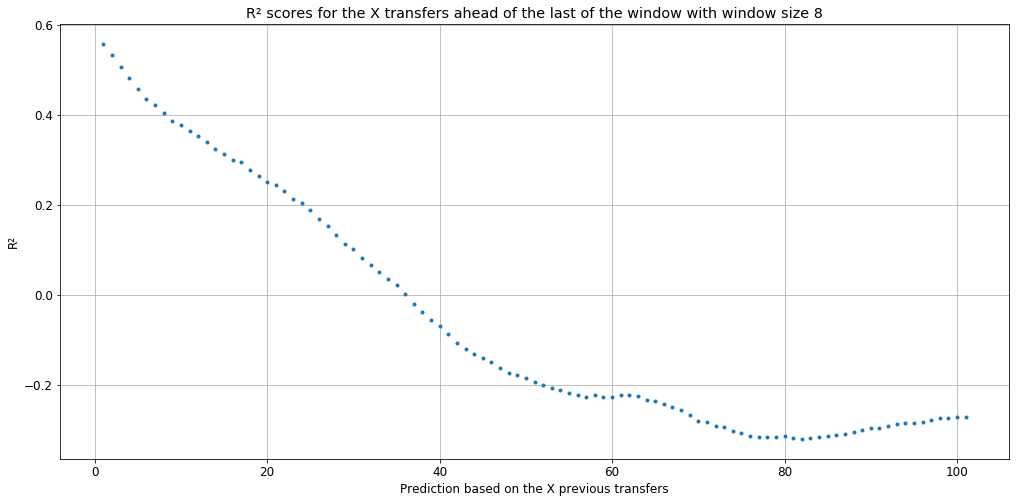

In [83]:
plt.plot(range(1,102),r2_scores_ahead, '.')
plt.title('R² scores for the X transfers ahead of the last of the window with window size 8')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Prediction based on the 8 previous transfers')
plt.ylabel('R²')

fig = plt.gcf()
fig.set_size_inches(17, 8)
#plt.legend()
plt.grid()
plt.show()

#### Make predictions ahead of the window for all the window sizes

In [89]:
r2_scores_ahead = [[]]*100
for winsize in range(1,101):
    r2_scores_ahead[winsize-1] = []
    pred = cut['N_PRED_%d'%winsize].values
    r2_scores_ahead[winsize-1].append(r2(cut.N_RATE, pred))
    for t_ahead in range(1,100):
        pred = np.append(np.zeros(t_ahead), cut['N_PRED_%d'%winsize].values)[:-t_ahead]
        r2_scores_ahead[winsize-1].append(r2(cut.N_RATE, pred))
r2s = np.array(r2_scores_ahead)
len(r2s[0].tolist())

100

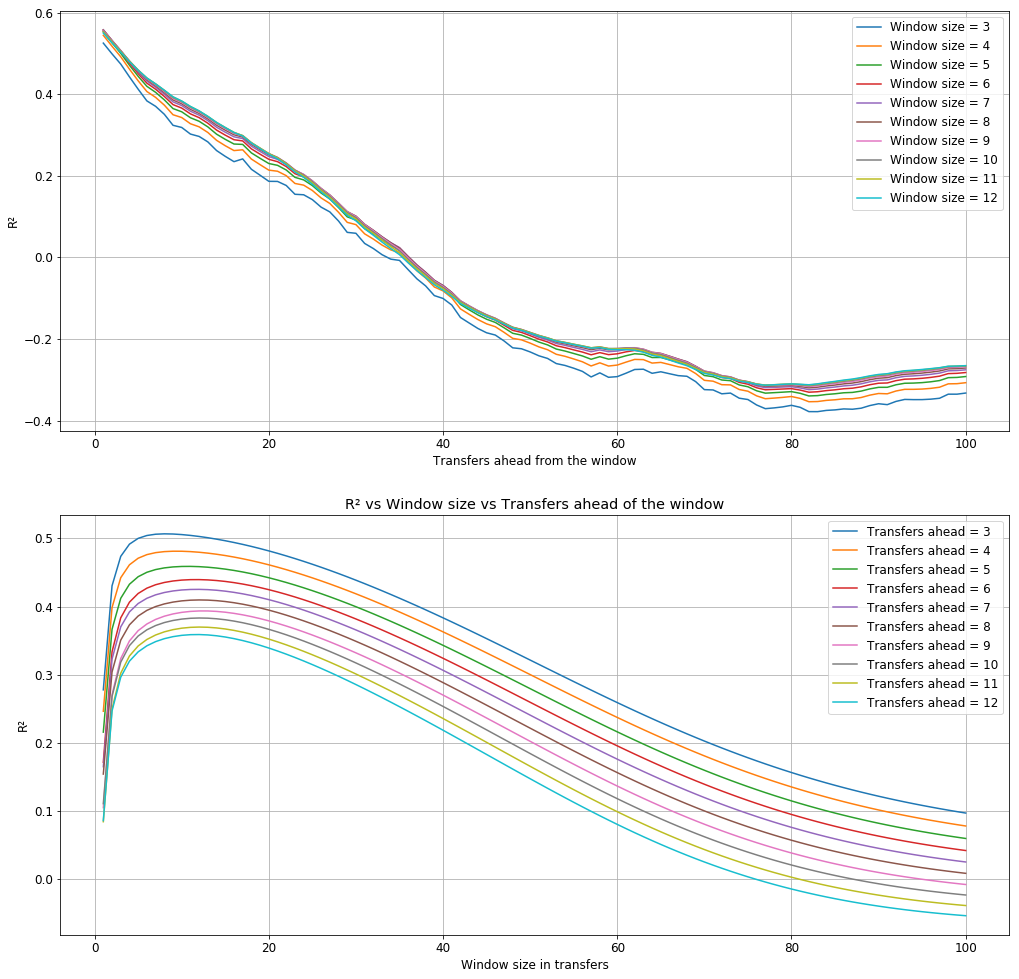

In [132]:
fig, (ax1, ax2) = plt.subplots(2, 1)
for ws in range(2,12,1):
    ax1.plot(range(1,101),r2s[ws], '-', label='Window size = %d'%(ws+1))
    ax2.plot(range(1,101),r2s.T[ws], '-', label='Transfers ahead = %d'%(ws+1))
    fig = plt.gcf()
plt.title('R² vs Window size vs Transfers ahead of the window')
ax1.set_xlabel('Transfers ahead from the window')
ax2.set_xlabel('Window size in transfers')
ax1.set_ylabel('R²')
ax2.set_ylabel('R²')
fig.set_size_inches(17, 17)
ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()
plt.show()

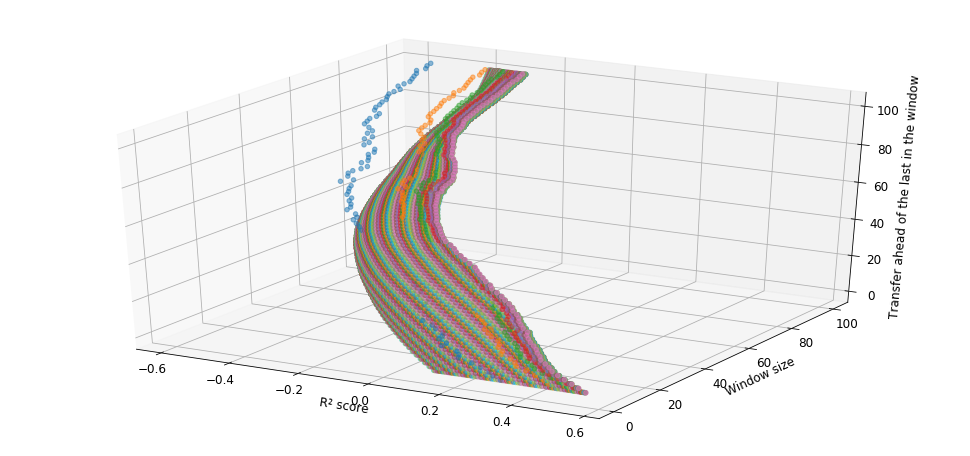

In [112]:
from mpl_toolkits.mplot3d import Axes3D
fplot = plt.figure().gca(projection='3d')
for i in range(100):
    fplot.scatter3D(r2s[i],range(1,101), range(1,101),alpha=0.5)
#fplot.scatter(cut.SIZE_MB,cut.LINK_RATE,cut.N_PRED,'o',alpha=0.5)
fplot.set_ylabel('Window size')
fplot.set_xlabel('R² score')
fplot.set_zlabel('Transfer ahead of the last in the window')
fig = plt.gcf()
fig.set_size_inches(17, 8)
#plt.legend()
plt.grid()
plt.show()